In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
!ls german-traffic-signs/

signnames.csv
test.p
train.p
valid.p


In [3]:
# cuda fail fixing
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

In [4]:
np.random.seed(0)

In [5]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f: 
    test_data = pickle.load(f)
print(type(train_data))
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images not equal to the number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 32 3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 32 3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 32 3"

In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


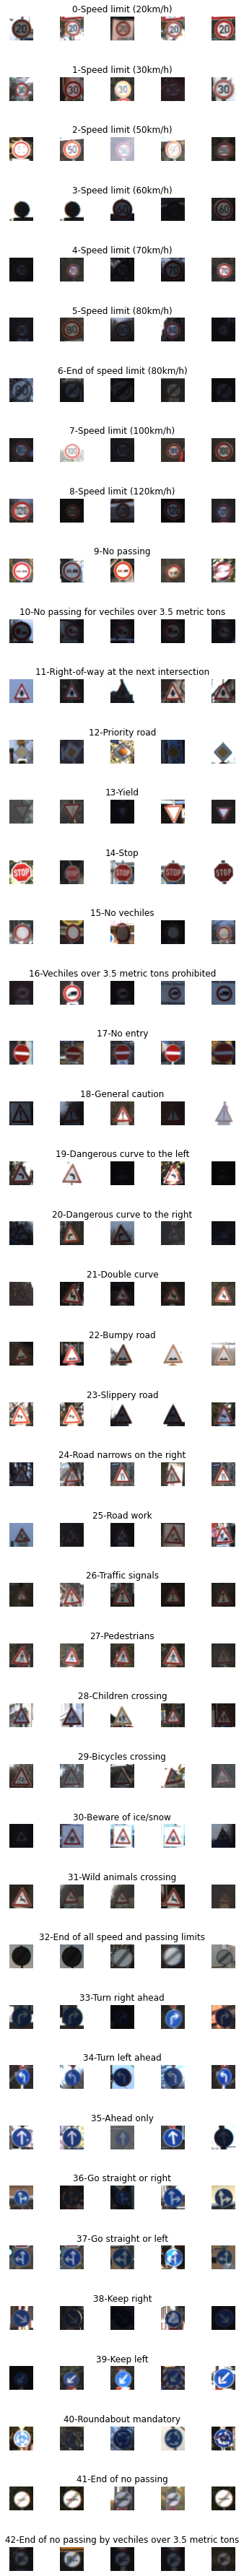

In [9]:
num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis('off')
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


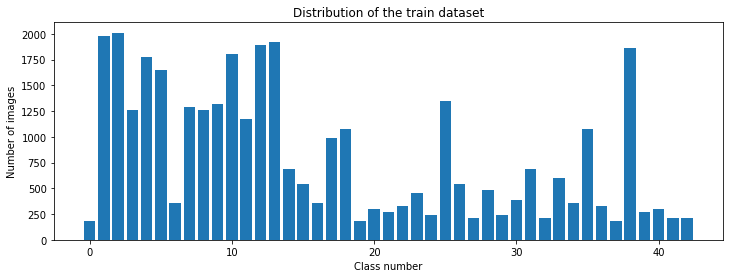

In [10]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


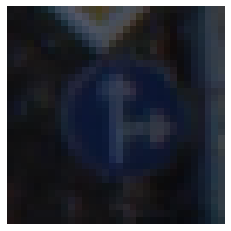

In [11]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [12]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [13]:
def equalize(img):
    cv2.equalizeHist(img)
    return img

In [14]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))


(34799, 32, 32)


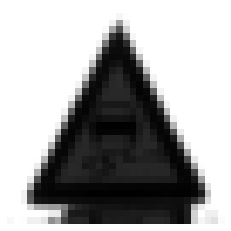

In [15]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap=plt.get_cmap('gray'))
plt.axis("off")
print(X_train.shape)

In [16]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [17]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                  height_shift_range=0.1,
                  zoom_range=0.2,
                  shear_range=0.1,
                  rotation_range=10)
datagen.fit(X_train)

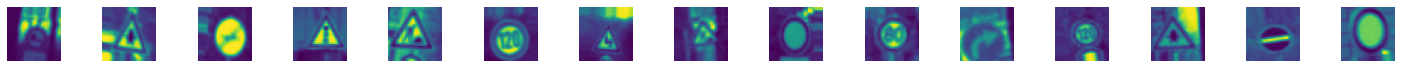

In [18]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis('off')

In [19]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [20]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [21]:
def leNet_model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))
    model.add(Conv2D(60, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
#    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [22]:
model = leNet_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0

In [23]:
history = model.fit(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 600, epochs = 10, validation_data = (X_val, y_val), shuffle = 1)
#(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size= 400, verbose = 1, shuffle = 1)

Epoch 1/10
600/600 [==============================] - 14s 12ms/step - loss: 2.9773 - accuracy: 0.1991 - val_loss: 0.5614 - val_accuracy: 0.8295
Epoch 2/10
600/600 [==============================] - 7s 11ms/step - loss: 0.8371 - accuracy: 0.7460 - val_loss: 0.2664 - val_accuracy: 0.9304
Epoch 3/10
600/600 [==============================] - 7s 11ms/step - loss: 0.4734 - accuracy: 0.8544 - val_loss: 0.1996 - val_accuracy: 0.9467
Epoch 4/10
600/600 [==============================] - 7s 11ms/step - loss: 0.3730 - accuracy: 0.8852 - val_loss: 0.1706 - val_accuracy: 0.9621
Epoch 5/10
600/600 [==============================] - 7s 11ms/step - loss: 0.2695 - accuracy: 0.9183 - val_loss: 0.1621 - val_accuracy: 0.9571
Epoch 6/10
600/600 [==============================] - 7s 11ms/step - loss: 0.2269 - accuracy: 0.9297 - val_loss: 0.0894 - val_accuracy: 0.9728
Epoch 7/10
600/600 [==============================] - 7s 11ms/step - loss: 0.2043 - accuracy: 0.9372 - val_loss: 0.1169 - val_accuracy: 0.967

Text(0.5, 0, 'epoch')

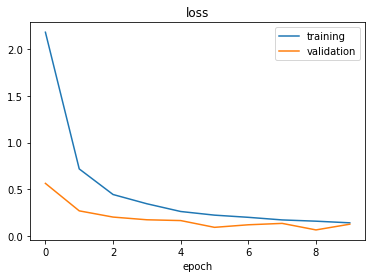

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

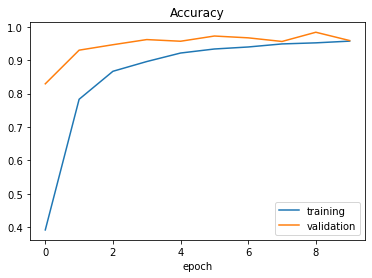

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [26]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.2229733020067215
Test accuracy: 0.9500395655632019


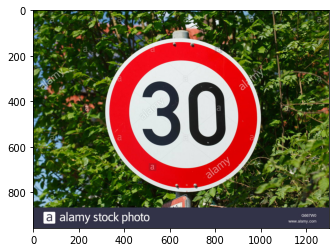

In [35]:
#fetch image
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


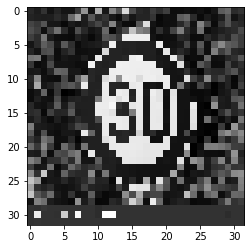

In [36]:
#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [37]:
#Reshape reshape
img = img.reshape(1, 32, 32, 1)

In [38]:
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [1]
